<a href="https://colab.research.google.com/github/Elrn/XAI/blob/main/GuidedBackprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset


Tensorflow version:  2.6.0
--2021-09-15 16:49:41--  https://raw.githubusercontent.com/nguyenhoa93/GradCAM_and_GuidedGradCAM_tf2/master/assets/samples/cat1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34547 (34K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>]  33.74K  --.-KB/s    in 0s      

2021-09-15 16:49:41 (102 MB/s) - ‘cat1.jpg’ saved [34547/34547]



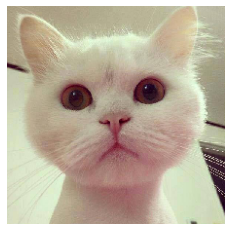

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)

H, W = 224, 224
# Reference: https://github.com/eclique/keras-gradcam/blob/master/grad_cam.py
def build_model():
  return ResNet50(include_top=True,weights="imagenet")

def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

# model = build_model()

# Download example image
!wget https://raw.githubusercontent.com/nguyenhoa93/GradCAM_and_GuidedGradCAM_tf2/master/assets/samples/cat1.jpg

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Origin image
plt.imshow(load_image("./cat1.jpg", preprocess=False))
plt.axis("off");

# process example input
preprocessed_input = load_image("./cat1.jpg")



# build model

In [ ]:
# model = build_model()
model = tf.keras.applications.ResNet50()

gb_model = Model(
    inputs = [model.inputs],
    # outputs = [model.get_layer("conv5_block3_out").output]
    outputs = [model.layers[-3].output]
)

---

# |x| * dy

In [ ]:
@tf.custom_gradient
def _GuidedReluGrad(x):
    def grad(dy):
        return dy * tf.cast(x>0, "float32")
    return tf.nn.relu(x), grad

def exchange_activation(model):
    for layer in [layer for layer in model.layers]:
        # print(layer)
        if 'activations' in str(layer): # tf.keras.layers.ELU()
            # print(f'layer: {layer}')
            continue
        if 'Activation' in str(layer): # tf.keras.layers.Activation()
            # print(f'core: {layer}')
            layer.activation = _GuidedReluGrad

exchange_activation(gb_model)

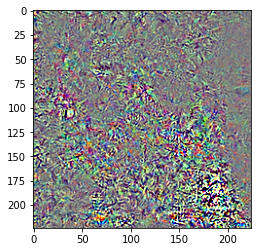

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)

grads = tape.gradient(outputs, inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))


# |x| * |dy|

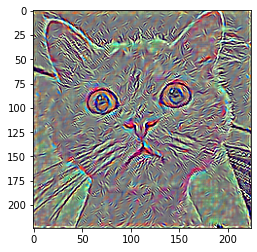

In [ ]:
@tf.custom_gradient
def _GuidedReluGrad(x):
    def grad(dy):
        return tf.cast(x>0, "float32") * tf.cast(dy>0, "float32")
    return tf.nn.relu(x), grad

exchange_activation(gb_model)

with tf.GradientTape(persistent=True) as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)

grads = tape.gradient(outputs, inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))

# |dy|

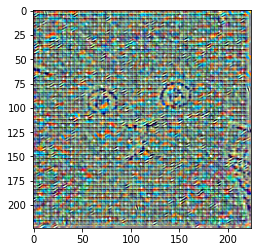

In [ ]:
@tf.custom_gradient
def _GuidedReluGrad(x):
    def gradient(dy):
        return tf.cast(dy>0, "float32")
    return tf.nn.relu(x), gradient

exchange_activation(gb_model)

with tf.GradientTape(persistent=True) as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)

grads = tape.gradient(outputs, inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))

# |dy|


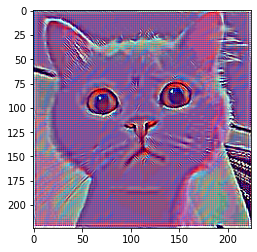

In [ ]:
@tf.custom_gradient
def _GuidedReluGrad(x):
    def gradient(dy):
        return tf.cast(x>0, "float32")
    return tf.nn.relu(x), gradient

exchange_activation(gb_model)

with tf.GradientTape(persistent=True) as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)

grads = tape.gradient(outputs, inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))

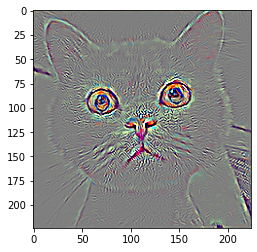

In [ ]:
@tf.custom_gradient
def _GuidedReluGrad(x):
    def gradient(dy):
        return tf.cast(x>0, "float32") * tf.nn.relu(dy)
    return tf.nn.relu(x), gradient

exchange_activation(gb_model)

with tf.GradientTape(persistent=True) as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)

grads = tape.gradient(outputs, inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))

# etc


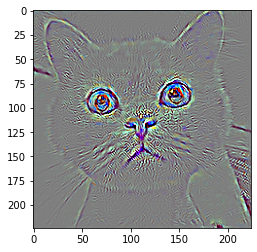

In [ ]:
@tf.custom_gradient
def backpropagation(x): # very noisy
    def gradient(dy):
        return dy * tf.cast(x>0, "float32")
    return tf.nn.relu(x), gradient

@tf.custom_gradient
def backward(x):
    def gradient(dy):
        return tf.nn.relu(dy)
    return tf.nn.relu(x), gradient

@tf.custom_gradient
def guided_backpropagation(x):
    def gradient(dy):
        return tf.cast(x>0, "float32") * tf.nn.relu(dy)
    return tf.nn.relu(x), gradient

layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')] # convolution layer 와 relu layer 를 포함
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu: # relu layer 일 경우
        layer.activation = guided_backpropagation

with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs) 

grads = tape.gradient(outputs, inputs)[0]

# plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
plt.imshow(deprocess_image(np.array(grads)))

In [ ]:
@tf.custom_gradient
def bar(x, y):
    def grad(upstream):
        dz_dx = y
        dz_dy = x
        print(f'upstream:{upstream}, dz_dx:{y}, dz_dy:{x}')
        return upstream * dz_dx, upstream * dz_dy
    z = x * y
    return z, grad

x = tf.constant(2.0, dtype=tf.float32)
y = tf.constant(3.0, dtype=tf.float32)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    z = bar(x, y) # 6
    print(f'z:{z}')
    z1 = bar(z, 4.0) # 24 / z * 4
    print(f'z1:{z1}')

print(tape.gradient(z, x)) # >>> 3
print(tape.gradient(z1, x)) # 18, 3 >>> 12
# dz/dx * dz1/dz = 3 * 4 = 12


# tape.gradient(z1, y)

z:6.0
z1:24.0
upstream:1.0, dz_dx:3.0, dz_dy:2.0
tf.Tensor(3.0, shape=(), dtype=float32)
upstream:1.0, dz_dx:4.0, dz_dy:6.0
upstream:4.0, dz_dx:3.0, dz_dy:2.0
tf.Tensor(12.0, shape=(), dtype=float32)


In [ ]:
@tf.custom_gradient
def bar(x):
    def grad(upstream):
        return upstream * dz_dx
    return tf.nn.relu(x), grad

x = tf.constant(-2.0, dtype=tf.float32)
# y = tf.constant(3.0, dtype=tf.float32)
# with tf.GradientTape(persistent=True) as tape:
with tf.GradientTape() as tape:
    tape.watch(x)
    print(tape.gradient(tf.nn.relu(x), x))

tf.Tensor(0.0, shape=(), dtype=float32)
